In [2]:
import pandas as pd
import numpy as np
from scipy.special import gamma, factorial
from scipy.stats import expon
import matplotlib.pyplot as plt

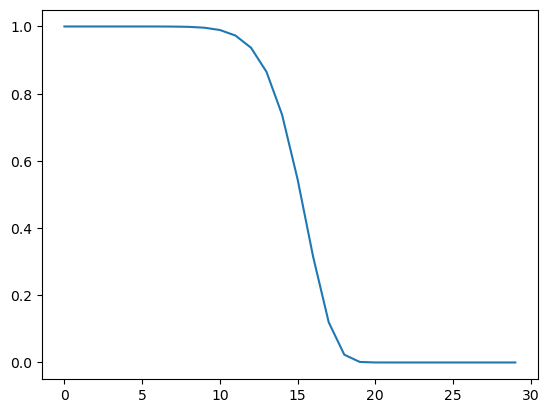

In [3]:
b = 10
yav = 15
y = np.arange(0,30)
shape = np.exp(-((y/yav)**b)*gamma(1+1/b)**b)
plt.plot(y, shape)